In [1]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib notebook
from IPython.display import HTML
import time
import datetime
import json

#Import usual things required for graph nets
import numpy as np
import pandas as pd
import networkx as nx
import sonnet as snt
import tensorflow as tf
import os
import sys

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Polygon

import seaborn as sns
from sklearn.model_selection import train_test_split

#Import graph nets
from graph_nets import blocks
from graph_nets import utils_tf
from graph_nets import utils_np

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Num GPUs Available:  1


In [2]:
#Path to the scripts shared troughout phases
parent_path=os.path.abspath('..')
path_common =  '\\'.join(parent_path.split('\\')[:-2]) 

#Check if path exists
path_common_scripts = os.path.join(path_common,'Common','Scripts')
if(not os.path.exists(path_common_scripts)):
    print('The path: '+ path_common_scripts+' is not found!')
path_common = os.path.join(path_common,'Common')
#Check if path exists
if(not os.path.exists(path_common)):
    print('The path: '+ path_common+' is not found!')



#Add shared scripts to our current paths for importing
sys.path.insert(0, path_common_scripts)

#Retrieve test specification document
test_spec_json = os.path.join(path_common,'hyper_parameters.json')
#Check if file exists
if(not os.path.exists(test_spec_json)):
    print('The file: '+ test_spec_json+' is not found!')
with open(test_spec_json) as f:
    test_spec = json.load(f)
    
params = test_spec['parameters']

model_params = params['model_parameters']

experiment_params = params['experiment_parameters']




#Save experiment begin date
current_time = datetime.datetime.now()
print("Current_date: "+str(current_time))
current_time = "".join(current_time.strftime("%x").split('/'))

NUM_TRAINING_ITERATIONS = experiment_params['number_of_training_iterations']
BATCH_SIZE_TR = experiment_params['training_batch_size']
BATCH_SIZE_TE = experiment_params['testing_batch_size']
BATCH_SIZE_GE = experiment_params['generalisation_batch_size']
NUM_PROCESSING_STEPS_TR = experiment_params['number_of_processing_steps_tr']
NUM_PROCESSING_STEPS_TE = experiment_params['number_of_processing_steps_te']
NUM_PROCESSING_STEPS_GE = experiment_params['number_of_processing_steps_ge']

FUL_LATENT_SIZE = model_params['ful_block_latent_size']
FUL_LAYER_NUMBER = model_params['ful_block_number_of_layers']
IND_LATENT_SIZE = model_params['ind_block_latent_size']
IND_LAYER_NUMBER = model_params['ind_block_number_of_layers']


# Folder description to distinguish between experiment runs
desc = "ntr="+str(NUM_TRAINING_ITERATIONS)
desc = desc +"_btr="+str(BATCH_SIZE_TR)
desc = desc +"_date="+str(current_time)

#Set seed
SEED = 8973
desc = desc +"seed="+str(SEED)


np.random.seed(SEED)
rand = np.random.RandomState(SEED)
tf.random.set_seed(SEED)

Current_date: 2021-04-06 14:35:43.301121


In [3]:
base = os.getcwd()
if(not os.path.exists(base)):
    os.makedirs(base)
    
#Path to saved models and trajectories
path_saves = os.path.join(base,desc,'Saves')
if(not os.path.exists(path_saves)):
    os.makedirs(path_saves)
    
#Path to plots
path_plots = os.path.join(base,desc,'Plots')
if(not os.path.exists(path_plots)):
    os.makedirs(path_plots)
    
#Path to animations
path_animations = os.path.join(base,desc,'Animations')
if(not os.path.exists(path_animations)):
    os.makedirs(path_animations)
    
#Save the used parameters as a json file into this folder
with open(os.path.join(path_saves,'specification.json'), 'w') as fp:
    json.dump(test_spec, fp)
    
#Path to Datasets
path_dataset = os.path.abspath('..\\..\\..\\..\\..')
path_dataset = os.path.join(path_dataset,'Data')

if(not os.path.exists(path_dataset)):
    print("Data folder does not exist.")

In [4]:
# Import model
import GNNModels_tf2 as models
# Import training plot
from TrainingPlot import training_plot, training_plot_log_scale
# Import functions for creating graph
from Graph_creator_functions import rigid_graph_from_pos_all, rigid_graph_from_pos_closest
# Import data loader module
from PushDatasetLoad import load_dataset, collect_trajectory_indeces, create_train_valid_test, collect_states, remove_effector, outlier_remover
# Import Dataset Feeder function
from PushDatasetFeed import DataFeeder
# Import simulation functions
from PushDatasetSimulator import PushDatasetSimulator
# Import function for experiments
from LossFunctions import velocity_loss_single_step, make_all_runnable_in_session
# Import visualisation functions
from VisualisationFunctions import visualise_trajectory, visualise_groundtruth

## Data loading:
In this section of the code we load the data. Split the trajectories into training, validation and testing sets.

In [5]:
# Set paths:
file_1 = os.path.join(path_dataset, "Rect1_Data50ms_1_of_2_flagged.csv")
file_2 = os.path.join(path_dataset, "Rect1_Data50ms_2_of_2_flagged.csv")
# Load dataset
df_set_1, STEP_SIZE = load_dataset(file_1)
df_set_2, STEP_SIZE = load_dataset(file_2)
# Collect trajectory indeces
VEL_ACCS = ['10.0-0.0']
trajectory_indeces,df_set_1 = collect_trajectory_indeces(df_set_1, ts = STEP_SIZE, vel_accs = VEL_ACCS)
_, df_set_2 = collect_trajectory_indeces(df_set_2, ts = STEP_SIZE, vel_accs = VEL_ACCS)
# Split indeces so that no trajectory is contained in both train, validation or test datasets
tr_inds, va_inds, te_inds = create_train_valid_test(trajectory_indeces, 0.25)
# Collect trajectories from these 
df_tr_1 = collect_states(tr_inds, df_set_1)
df_tr_2 = collect_states(tr_inds, df_set_2)
df_va_1 = collect_states(va_inds, df_set_1)
df_va_2 = collect_states(va_inds, df_set_2)
df_te_1 = collect_states(te_inds, df_set_1)
df_te_2 = collect_states(te_inds, df_set_2)

# Remove Outliers
df_tr_1, df_tr_2 = outlier_remover(df_tr_1, df_tr_2)
df_va_1, df_va_2 = outlier_remover(df_va_1, df_va_2)
df_te_1, df_te_2 = outlier_remover(df_te_1, df_te_2)


df_dict = {"tr_1":df_tr_1, 
           "tr_2":df_tr_2, 
           "va_1":df_va_1,
           "va_2":df_va_2,
           "te_1":df_te_1,
           "te_2":df_te_2,}

C:\Users\vbenc\miniconda3\envs\Honours\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\vbenc\miniconda3\envs\Honours\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


['10.0-0.0']
['10.0-0.0']
['10.0-0.0']


# Train

In [6]:
# Create the model.
model = models.EncodeProcessDecode(ind_layer_numbers = IND_LAYER_NUMBER,
                                   ind_latent_unit_size = IND_LATENT_SIZE,
                                   ful_layer_numbers = FUL_LAYER_NUMBER,
                                   ful_latent_unit_size = FUL_LATENT_SIZE,
                                   node_output_size=2,
                                   edge_output_size=2,
                                   global_output_size=1)



LEARNING_RATE = model_params['learning_rate']
#optimizer = tf.keras.optimizers.Adam()
optimizer = snt.optimizers.Adam(LEARNING_RATE)

In [7]:
def update_step(inputs_tr, targets_tr):
    with tf.GradientTape() as tape:
        outputs_tr = model(inputs_tr, 1)
        # Only Nodes
        outputs_tr_nodes = outputs_tr[0].nodes
        targets_tr_nodes = targets_tr.nodes
        # Loss
        #print(outputs_tr_nodes)
        #print(targets_tr_nodes)
        #c_output_tr_nodes, c_target_tr_nodes = remove_effector(outputs_tr_nodes, targets_tr_nodes)
        loss_tr = velocity_loss_single_step(targets_tr, outputs_tr[0])
    
    gradients = tape.gradient(loss_tr, model.trainable_variables)
    optimizer.apply(gradients, model.trainable_variables)
    return outputs_tr, loss_tr, gradients

def test_step(inputs, targets):
    outputs = model(inputs, 1)
    # Only Nodes
    output_nodes = outputs[0].nodes
    target_nodes = targets.nodes
    # Loss
    #c_output_nodes, c_target_nodes = remove_effector(output_nodes, target_nodes)
    loss = velocity_loss_single_step(targets, outputs[0])
    
    return loss

In [8]:
feeder = DataFeeder(SEED)
#Get some example data that resembles the tensors that will be fed
# into update_step():
d = feeder.get_data(dfs = df_dict,
                    tr_batch_size = BATCH_SIZE_TR,
                    va_batch_size = BATCH_SIZE_GE,
                    te_batch_size = BATCH_SIZE_TE,
                    graph_creator = rigid_graph_from_pos_all)

X_tr = d["X_tr"]
Y_tr = d["Y_tr"]

# Get the input signature for that function by obtaining the specs
input_signature = [
  utils_tf.specs_from_graphs_tuple(X_tr),
  utils_tf.specs_from_graphs_tuple(Y_tr)
]

# Compile the update function using the input signature for speedy code.
compiled_update_step = tf.function(update_step, input_signature=input_signature)

In [9]:
# Setup logging
last_iteration = 0
logged_iterations = []
losses_step_tr = []
losses_step_va = []
losses_step_te = []
gradients = []

log_every_iteration = 5

print("# (iteration number) out of max iteration, T (elapsed seconds), "
      "Ltr, "
      "Lte, "
      "Lge")


feeder = DataFeeder(SEED)

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, NUM_TRAINING_ITERATIONS):
    last_iteration = iteration
    do_logging = (last_iteration % log_every_iteration == 0)
    
    
    data = feeder.get_data(dfs = df_dict, 
                 tr_batch_size = BATCH_SIZE_TR,
                 va_batch_size = BATCH_SIZE_GE,
                 te_batch_size = BATCH_SIZE_TE,
                 graph_creator = rigid_graph_from_pos_all, 
                 te_and_va = do_logging)
    
    X_tr = data["X_tr"]
    Y_tr = data["Y_tr"]
    
    
    
    # Do one tick of training    
    outputs_tr, loss_tr, gradient = compiled_update_step(X_tr, Y_tr)
    
    # Don't log at every iteration
    if do_logging:
        X_va = data["X_va"]
        Y_va = data["Y_va"]
        X_te = data["X_te"]
        Y_te = data["Y_te"]
        # Validation and Test
        loss_va = test_step(X_va, Y_va)
        loss_te = test_step(X_te, Y_te)
        
        # Convert losses to normal values
        loss_tr = loss_tr[0].numpy()
        loss_va = loss_va[0].numpy()
        loss_te = loss_te[0].numpy()
        
        the_time = time.time()
        elapsed_since_last_log = the_time - last_log_time
        last_log_time = the_time
        
        # Log data into lists
        elapsed = time.time() - start_time
        losses_step_tr.append(loss_tr)
        if loss_tr > 1.0:
            print(data["tr_indeces"])
        losses_step_va.append(loss_va)
        losses_step_te.append(loss_te)
        gradients.append(gradient)
        
        logged_iterations.append(iteration)
        
        print("# {:05d}, Max {:05d}, T {:.1f}, Ltr {:.6f}, Lva {:.6f}, Lte {:.6f}".format(
            iteration, NUM_TRAINING_ITERATIONS, elapsed, loss_tr, loss_va, loss_te))
    
    

# (iteration number) out of max iteration, T (elapsed seconds), Ltr, Lte, Lge
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


C:\Users\vbenc\miniconda3\envs\Honours\lib\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/EncodeProcessDecode/Processor/graph_network/edge_block/broadcast_receiver_nodes_to_edges/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/EncodeProcessDecode/Processor/graph_network/edge_block/broadcast_receiver_nodes_to_edges/Reshape:0", shape=(None, 512), dtype=float32), dense_shape=Tensor("gradient_tape/EncodeProcessDecode/Processor/graph_network/edge_block/broadcast_receiver_nodes_to_edges/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
C:\Users\vbenc\miniconda3\envs\Honours\lib\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/EncodePr

# 00000, Max 01000, T 11.0, Ltr 0.524141, Lva 15.587674, Lte 15.642329
# 00005, Max 01000, T 15.7, Ltr 0.387617, Lva 0.132731, Lte 0.131195
# 00010, Max 01000, T 20.2, Ltr 0.050597, Lva 0.004415, Lte 0.004403
# 00015, Max 01000, T 24.9, Ltr 0.006364, Lva 0.005668, Lte 0.005631
# 00020, Max 01000, T 29.6, Ltr 0.003164, Lva 0.002619, Lte 0.002576
# 00025, Max 01000, T 34.1, Ltr 0.002651, Lva 0.000878, Lte 0.000882
# 00030, Max 01000, T 38.7, Ltr 0.000451, Lva 0.002472, Lte 0.002385
# 00035, Max 01000, T 43.3, Ltr 0.000578, Lva 0.003121, Lte 0.003135
# 00040, Max 01000, T 48.0, Ltr 0.001268, Lva 0.002668, Lte 0.002615
# 00045, Max 01000, T 52.5, Ltr 0.001579, Lva 0.001447, Lte 0.001441
# 00050, Max 01000, T 57.3, Ltr 0.001075, Lva 0.000482, Lte 0.000464
# 00055, Max 01000, T 61.8, Ltr 0.000441, Lva 0.000081, Lte 0.000089
# 00060, Max 01000, T 66.5, Ltr 0.000070, Lva 0.000151, Lte 0.000157
# 00065, Max 01000, T 71.2, Ltr 0.000128, Lva 0.000271, Lte 0.000251
# 00070, Max 01000, T 75.9, Ltr 

# 00590, Max 01000, T 553.6, Ltr 0.000052, Lva 0.000044, Lte 0.000052
# 00595, Max 01000, T 558.2, Ltr 0.000052, Lva 0.000050, Lte 0.000047
# 00600, Max 01000, T 562.8, Ltr 0.000053, Lva 0.000048, Lte 0.000049
# 00605, Max 01000, T 567.3, Ltr 0.000068, Lva 0.000046, Lte 0.000056
# 00610, Max 01000, T 571.8, Ltr 0.000053, Lva 0.000047, Lte 0.000055
# 00615, Max 01000, T 576.5, Ltr 0.000049, Lva 0.000048, Lte 0.000046
# 00620, Max 01000, T 581.0, Ltr 0.000051, Lva 0.000046, Lte 0.000049
# 00625, Max 01000, T 585.6, Ltr 0.000050, Lva 0.000050, Lte 0.000059
# 00630, Max 01000, T 590.4, Ltr 0.000050, Lva 0.000050, Lte 0.000054
# 00635, Max 01000, T 594.8, Ltr 0.000053, Lva 0.000048, Lte 0.000057
# 00640, Max 01000, T 599.3, Ltr 0.000052, Lva 0.000047, Lte 0.000047
# 00645, Max 01000, T 603.8, Ltr 0.000049, Lva 0.000045, Lte 0.000055
# 00650, Max 01000, T 608.4, Ltr 0.000051, Lva 0.000046, Lte 0.000048
# 00655, Max 01000, T 612.8, Ltr 0.000051, Lva 0.000052, Lte 0.000053
# 00660, Max 01000, 

## Saving losses

In [10]:
def save_data(name, data):
    data = np.array(data)
    if os.path.exists(os.path.join(path_saves, name)):
        print("The file: "+ name + " already exists. Delete it before saving a new trajectory!")
    else:
        if not os.path.exists(os.path.join(path_saves)):
            os.makedirs(os.path.join(path_saves)) 
            
        np.save(os.path.join(path_saves, name), data)

save_data("iterations", logged_iterations)
save_data("losses_tr", losses_step_tr)
save_data("losses_te", losses_step_te)
save_data("losses_va", losses_step_va)
save_data("gradients", gradients)


C:\Users\vbenc\miniconda3\envs\Honours\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


<IPython.core.display.Javascript object>


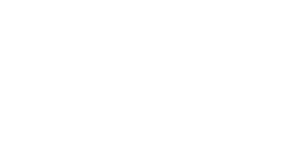

In [11]:
plt.close('all')
fig, ax = training_plot(logged_iterations, losses_step_tr, losses_step_va, losses_step_te, path_plots)
plt.show()

<IPython.core.display.Javascript object>


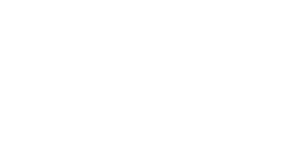

In [12]:
plt.close('all')
fig, ax = training_plot_log_scale(logged_iterations, losses_step_tr, losses_step_va, losses_step_te, path_plots)
plt.show()

## Evaluation

In [13]:
# Parameters for the visualisation 
ROLLOUT_BATCH_SIZE = 1
ROLLOUT_TIMESTEPS = 50

sim = PushDatasetSimulator(rollout_steps = ROLLOUT_TIMESTEPS, 
                           step_size = STEP_SIZE,
                           batch_size = ROLLOUT_BATCH_SIZE)

# Get trajectory from the dataset
X_g, Y_g, i_np = sim.get_trajectories(df_te_1, df_te_2, rigid_graph_from_pos_all)

# Convert trajectories into graphs
traj_X, traj_Y = sim.convert_trajectories(X_g,Y_g)
# Predict trajectory using the model
pred_trajectory, real_trajectory = sim.predict_trajectory_velocity(model, traj_X, traj_Y)

<IPython.core.display.Javascript object>


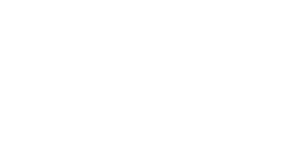

In [14]:
plt.close('all')
fig, ax, anim = visualise_trajectory(pred_trajectory, real_trajectory, ROLLOUT_TIMESTEPS)
anim.save(os.path.join(path_animations,'visualisation.gif'), writer='imagemagick', fps=60)
plt.close('all')
HTML(anim.to_jshtml())